In [1]:
import numpy as np
import pandas as pd
import sklearn
import cv2
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt
import sys
sys.path.append('..')

import torch
from torch import nn
from torch.autograd import Variable
from torchvision.datasets import mnist # 导入 pytorch 内置的 mnist 数据

In [2]:
def Elastic_transform(image, alpha, sigma):
    shape = image.shape
    shape_size = shape[:2]
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dz = np.zeros_like(dx)

    x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))

    return map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)

In [3]:
def elastic_transform(image, alpha, sigma, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_.
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dz = np.zeros_like(dx)

    x, y, z = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), np.arange(shape[2]))
    print(x.shape)
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))
 
    distored_image = map_coordinates(image, indices,order=1, mode='reflect')
    return distored_image.reshape(image.shape)

In [4]:
# Elastic transform
def elastic_transformations(alpha, sigma, rng=np.random.RandomState(42), 
                            interpolation_order=1):
    """Returns a function to elastically transform multiple images."""
    def _elastic_transform_2D(images):
        """`images` is a numpy array of shape (K, M, N) of K images of size M*N."""
        # Take measurements
        image_shape = images[0].shape
        # Make random fields
        dx = rng.uniform(-1, 1, image_shape) * alpha
        dy = rng.uniform(-1, 1, image_shape) * alpha
        # Smooth dx and dy
        sdx = gaussian_filter(dx, sigma=sigma, mode='reflect')
        sdy = gaussian_filter(dy, sigma=sigma, mode='reflect')
        # Make meshgrid
        x, y = np.meshgrid(np.arange(image_shape[1]), np.arange(image_shape[0]))
        # Distort meshgrid indices
        distorted_indices = (y + sdy).reshape(-1, 1), \
                            (x + sdx).reshape(-1, 1)
        # Map cooordinates from image to distorted index set
        transformed_images = [map_coordinates(image, distorted_indices, mode='reflect',
                                              order=interpolation_order).reshape(image_shape)
                              for image in images]
        return transformed_images
    return _elastic_transform_2D

In [5]:
# 使用内置函数下载 mnist 数据集
train_set = mnist.MNIST('./data', train=True, download=True)
test_set = mnist.MNIST('./data', train=False, download=True)

In [6]:
a_data, a_label = train_set[1]
a_data
#plt.imshow(a_data)

In [7]:
def data_tf(x):
    x = np.array(x, dtype='float32') / 255
    x = (x - 0.5) / 0.5 # 标准化，这个技巧之后会讲到
    x = x.reshape(1,28,28)
    x = torch.from_numpy(x)
    
    return x

train_set = mnist.MNIST('./data', train=True, transform=data_tf, download=True) # 重新载入数据集，申明定义的数据变换
test_set = mnist.MNIST('./data', train=False, transform=data_tf, download=True)

a, a_label = train_set[0]
print(a.shape)
print(a_label)

torch.Size([1, 28, 28])
5


In [8]:
from torch.utils.data import DataLoader
# 使用 pytorch 自带的 DataLoader 定义一个数据迭代器
train_data = DataLoader(train_set, batch_size=64, shuffle=True)
test_data = DataLoader(test_set, batch_size=128, shuffle=False)
print(train_data.dataset)
print(test_data.dataset)
a, a_label = next(iter(train_data))
# 打印出一个批次的数据大小
print(a.shape)
print(a_label.shape)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: <function data_tf at 0x000000001DE1F400>
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: <function data_tf at 0x000000001DE1F400>
torch.Size([64, 1, 28, 28])
torch.Size([64])


In [9]:
import cupy
def Random_affine(image,alpha_affine,random_state=None):
    if random_state is None:
        random_state = np.random.RandomState(None)
    shape = image.shape
    shape_size = shape[:2]
    # Random affine
    center_square = np.float32(shape_size) // 2
    square_size = min(shape_size) // 3
    pts1 = np.float32([center_square + square_size, 
                       [center_square[0]+square_size, center_square[1]-square_size],
                       center_square - square_size])
    pts2 = pts1 + random_state.uniform(-alpha_affine,
                                       alpha_affine, size=pts1.shape).astype(np.float32)
    M = cv2.getAffineTransform(pts1, pts2)

    image = cupy.asnumpy(image)
    image = cv2.warpAffine(image,M,shape_size[::-1],borderValue=-1)
    
    return image

(28, 28)


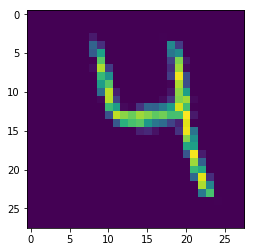

In [10]:
a_data, a_label = train_set[2]
a_data=np.reshape(a_data,(28,28))
a_data=Random_affine(a_data,4)
print(a_data.shape)

plt.imshow(a_data)

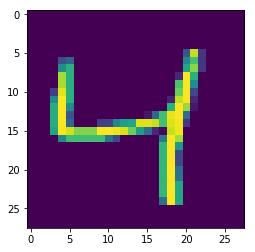

In [11]:
b_data, b_label = train_set[2]
b_data.shape
b_data=np.reshape(b_data,(28,28))
b_data
plt.imshow(b_data)

(1, 28, 28)


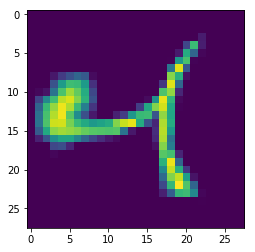

In [12]:
a_data, a_label = train_set[2]
a_data
k=elastic_transformations(34,4)
a_data=k(a_data)
#a_data=elastic_transform(a_data,34,4)
a_data=np.array(a_data, dtype='float32')
print(a_data.shape)

a_data=np.reshape(a_data,(28,28))


plt.imshow(a_data)


In [13]:
class SimpleConv(nn.Module):
    def __init__(self):
        super(SimpleConv,self).__init__()
        self.layer1=nn.Sequential(nn.Conv2d(1,5,kernel_size=5,stride=(2,2),padding=(1,1)),nn.BatchNorm2d(5),nn.Sigmoid())#5 13 13
        self.layer2=nn.Sequential(nn.Conv2d(5,50,kernel_size=5,stride=(2,2)),nn.BatchNorm2d(50),nn.Sigmoid()) #50 5 5
       
        self.fc=nn.Sequential(
            nn.Linear(5*5*50,100),
            nn.Sigmoid(),
            nn.Linear(100,10),
        )
        
    def forward(self,x):
        x =  self.layer1(x)
        x =  self.layer2(x)
        x =  x.view(x.size(0),-1)#展平
        x =  self.fc(x)
        return  x
        

In [14]:

print(torch.cuda.is_available())
if(torch.cuda.is_available()):
    net=SimpleConv().cuda()
    print("cuda")
else:
    net=SimpleConv()
net.train()

True
cuda


SimpleConv(
  (layer1): Sequential(
    (0): Conv2d(1, 5, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sigmoid()
  )
  (layer2): Sequential(
    (0): Conv2d(5, 50, kernel_size=(5, 5), stride=(2, 2))
    (1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sigmoid()
  )
  (fc): Sequential(
    (0): Linear(in_features=1250, out_features=100, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [15]:
import torch.optim as optim
from torch.optim import lr_scheduler
# 定义 loss 函数
loss_func  = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), 0.005) # 使用随机梯度下降，学习率 0.1
scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.3)


In [16]:
from datetime import datetime
def get_acc(output, label):
    total = output.shape[0]
    _, pred_label = output.max(1)
    num_correct = (pred_label == label).sum().item()
    return num_correct / total


def train(net, train_data, valid_data, num_epochs, optimizer, criterion,scheduler):
    if torch.cuda.is_available():
        net = net.cuda()
    prev_time = datetime.now()
    for epoch in range(num_epochs):
        scheduler.step()
        train_loss = 0
        train_acc = 0
        net = net.train()
        for im, label in train_data:
          new_data=[]
          train_list=[]
          train_list.append(im)
          '''
          for i in range(im.shape[0]):
              a_data=np.reshape(im[i],(28,28))
              affine=Random_affine(a_data,4)
              affine=np.reshape(affine,(1,28,28))
              new_data.append(affine)
          new_data=np.array(new_data)
          new_data=torch.from_numpy(new_data)
          #print("$$$",im.dtype,new_data.dtype)
          '''   
          for i in range(im.shape[0]):             
              ela_temp=elastic_transformations(34,4)
              elastic=ela_temp(im[i])
              elastic=np.array(elastic, dtype='float32')
              new_data.append(elastic)
                
                
          new_data=np.array(new_data)
          new_data=torch.from_numpy(new_data)
          train_list.append(new_data)

          for ims in train_list:
            if torch.cuda.is_available():
                ims = Variable(ims.cuda())  # (bs, 3, h, w)
                label = Variable(label.cuda())  # (bs, h, w)
            else:
                ims = Variable(ims)
                label = Variable(label)
            # forward
            #print(ims.shape)
            output = net(ims)
            loss = criterion(output, label)
            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += get_acc(output, label)

        cur_time = datetime.now()
        h, remainder = divmod((cur_time - prev_time).seconds, 3600)
        m, s = divmod(remainder, 60)
        time_str = "Time %02d:%02d:%02d" % (h, m, s)
        if valid_data is not None:
            valid_loss = 0
            valid_acc = 0
            net = net.eval()
            for im, label in valid_data:
                if torch.cuda.is_available():
                    im = Variable(im.cuda(), volatile=True)
                    label = Variable(label.cuda(), volatile=True)
                else:
                    im = Variable(im, volatile=True)
                    label = Variable(label, volatile=True)
                output = net(im)
                loss = criterion(output, label)
                valid_loss += loss.item()
                valid_acc += get_acc(output, label)
            epoch_str = (
                "Epoch %d. Train Loss: %f, Train Acc: %f, Valid Loss: %f, Valid Acc: %f, "
                % (epoch, train_loss / len(train_data),
                   train_acc / len(train_data), valid_loss / len(valid_data),
                   valid_acc / len(valid_data)))
        else:
            epoch_str = ("Epoch %d. Train Loss: %f, Train Acc: %f, " %
                         (epoch, train_loss / len(train_data),
                          train_acc / len(train_data)))
        prev_time = cur_time
        print(epoch_str + time_str)

In [21]:
#将预训练模型载入
net.load_state_dict(torch.load('./elastic.pth',map_location='cpu'))

<All keys matched successfully>

In [22]:

train(net, train_data, test_data, 150, optimizer, loss_func,scheduler=scheduler)


D:\anaconda\lib\site-packages\ipykernel_launcher.py:72: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
D:\anaconda\lib\site-packages\ipykernel_launcher.py:73: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Epoch 0. Train Loss: 0.161181, Train Acc: 1.949993, Valid Loss: 0.027298, Valid Acc: 0.990902, Time 00:02:12
Epoch 1. Train Loss: 0.159656, Train Acc: 1.950560, Valid Loss: 0.028896, Valid Acc: 0.990605, Time 00:02:10
Epoch 2. Train Loss: 0.164541, Train Acc: 1.949544, Valid Loss: 0.026324, Valid Acc: 0.991199, Time 00:02:12
Epoch 3. Train Loss: 0.165839, Train Acc: 1.950227, Valid Loss: 0.029156, Valid Acc: 0.990704, Time 00:02:14
Epoch 4. Train Loss: 0.164880, Train Acc: 1.949044, Valid Loss: 0.028317, Valid Acc: 0.991001, Time 00:02:13
Epoch 5. Train Loss: 0.162924, Train Acc: 1.949544, Valid Loss: 0.027917, Valid Acc: 0.990605, Time 00:02:10
Epoch 6. Train Loss: 0.163674, Train Acc: 1.949344, Valid Loss: 0.030294, Valid Acc: 0.989715, Time 00:02:11
Epoch 7. Train Loss: 0.161080, Train Acc: 1.950876, Valid Loss: 0.031469, Valid Acc: 0.990012, Time 00:02:10
Epoch 8. Train Loss: 0.164298, Train Acc: 1.948844, Valid Loss: 0.029004, Valid Acc: 0.990902, Time 00:02:12
Epoch 9. Train Loss

Epoch 74. Train Loss: 0.155183, Train Acc: 1.952475, Valid Loss: 0.025901, Valid Acc: 0.990902, Time 00:02:40
Epoch 75. Train Loss: 0.158780, Train Acc: 1.952242, Valid Loss: 0.026729, Valid Acc: 0.990902, Time 00:02:37
Epoch 76. Train Loss: 0.154239, Train Acc: 1.952942, Valid Loss: 0.027021, Valid Acc: 0.991100, Time 00:02:38
Epoch 77. Train Loss: 0.155024, Train Acc: 1.952042, Valid Loss: 0.026722, Valid Acc: 0.990902, Time 00:02:36
Epoch 78. Train Loss: 0.155401, Train Acc: 1.952659, Valid Loss: 0.026133, Valid Acc: 0.991297, Time 00:02:36
Epoch 79. Train Loss: 0.155012, Train Acc: 1.952492, Valid Loss: 0.026405, Valid Acc: 0.990902, Time 00:02:38
Epoch 80. Train Loss: 0.155190, Train Acc: 1.952709, Valid Loss: 0.025924, Valid Acc: 0.991297, Time 00:02:24
Epoch 81. Train Loss: 0.156194, Train Acc: 1.952725, Valid Loss: 0.025952, Valid Acc: 0.991001, Time 00:02:17
Epoch 82. Train Loss: 0.157837, Train Acc: 1.951792, Valid Loss: 0.026236, Valid Acc: 0.991100, Time 00:02:19
Epoch 83. 

Epoch 148. Train Loss: 0.152773, Train Acc: 1.953242, Valid Loss: 0.025427, Valid Acc: 0.991100, Time 00:02:16
Epoch 149. Train Loss: 0.159146, Train Acc: 1.950743, Valid Loss: 0.025952, Valid Acc: 0.990704, Time 00:02:15


In [20]:
#保存模型
model_path='./elastic.pth'
torch.save(net.state_dict(),model_path)